In [1]:
using TCI4Keldysh
using PythonCall
using PythonPlot
using HDF5

    CondaPkg Found dependencies: /home/m/M.Frankenbach/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Found dependencies: /home/m/M.Frankenbach/.julia/packages/PythonPlot/469aA/CondaPkg.toml
    CondaPkg Dependencies already up to date


In [2]:
basepath = joinpath(TCI4Keldysh.pdatadir(), "cluster_output")
folder = joinpath(basepath, "V_KF_conventional1.5")

V = h5read(joinpath(folder, "V_KF_p_R=8.h5"), "V_KF");

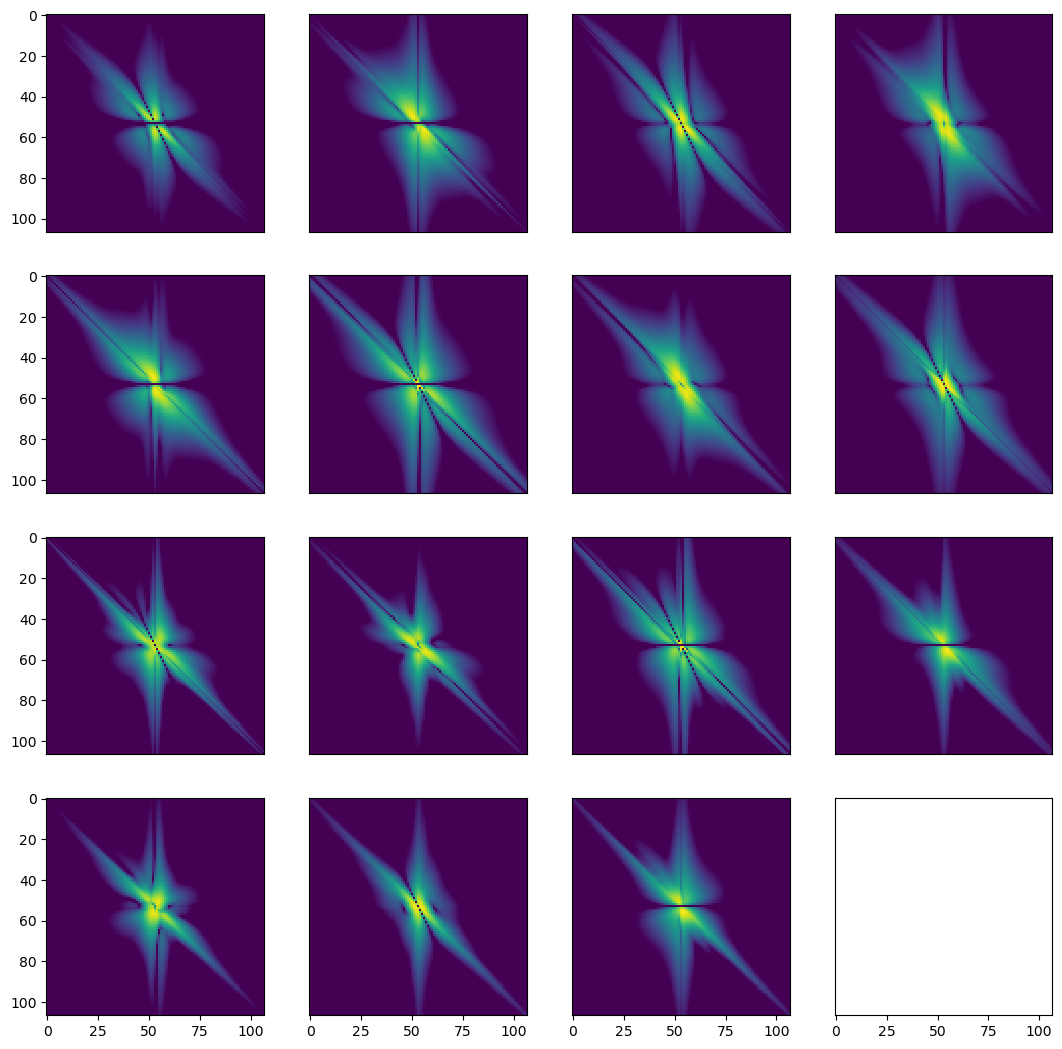

(1.59wsz) / 128 = 0.6583593750000001


In [86]:
# see all iK
fig, axs = subplots(4,4, figsize=(13,13))

slice_dim = 3
wsz = 53
for i in 1:4
    for j in 1:4
        iK = 4*(i-1) + j
        Vik = V[:,:,:, TCI4Keldysh.KF_idx(iK,3)...]
        tolint = -2
        vmax = log10(maximum(abs.(Vik)))
        vmin = vmax + tolint

        # plot
        szV = size(Vik)
        slice_idx = div(szV[slice_dim],2) - 0
        window = div(szV[1],2) - wsz : div(szV[1],2) + wsz
        slice = ntuple(i -> ifelse(i==slice_dim, slice_idx, window), 3)

        scfun(x) = log10(abs(x))

        p = axs[i-1,j-1].imshow(scfun.(Vik[slice...]), cmap="viridis", interpolation="nearest")
        # axs[i-1,j-1].set_title("$iK")
        axs[i-1,j-1].tick_params(axis="both", bottom=(i==4), labelbottom=(i==4), labelleft=(j==1), left=(j==1))
        p.set_clim(vmin, vmax)
    end
end

@show 1.59 * wsz/128

# fig.tight_layout()
display(fig)

In [59]:
# investigate impact of broadening


channel = "p"
ωmax = 0.318
flavor = 1
fac_lin = 1.1
fac_log = 1.1
base_path = "SIAM_u=0.50"
joinpath(TCI4Keldysh.datadir(), base_path, "PSF_nz=4_conn_zavg/")
PSFpath = joinpath(TCI4Keldysh.datadir(), base_path, "PSF_nz=4_conn_zavg/")

R = 4
(γref, sigmakref) = TCI4Keldysh.read_broadening_params(base_path; channel=channel)
T = TCI4Keldysh.dir_to_T(PSFpath)
ωconvMat = TCI4Keldysh.channel_trafo(channel)
ωs_ext = TCI4Keldysh.KF_grid(ωmax, R, 3)
om_sig = TCI4Keldysh.KF_grid_fer(ωmax, R+1)

broadening_kwargs = TCI4Keldysh.read_broadening_settings(joinpath(TCI4Keldysh.datadir(), base_path); channel=channel)
if !haskey(broadening_kwargs, "estep")
    broadening_kwargs[:estep] = 20
end

# with MuNRG broadening parameters
(Σ_L, Σ_R) = TCI4Keldysh.calc_Σ_KF_aIE_viaR(PSFpath, om_sig; T=T, flavor_idx=flavor, sigmak=sigmakref, γ=γref, broadening_kwargs...)
refval = TCI4Keldysh.compute_Γcore_symmetric_estimator(
    "KF",
    PSFpath*"4pt/",
    Σ_R;
    Σ_calcL=Σ_L,
    T,
    flavor_idx = flavor,
    ωs_ext = ωs_ext,
    ωconvMat=ωconvMat,
    sigmak=sigmakref, γ=γref,
    broadening_kwargs...
)

# with rescaled broadening parameters
γ = fac_lin*γref
sigmak = fac_log*sigmakref
(Σ_L, Σ_R) = TCI4Keldysh.calc_Σ_KF_aIE_viaR(PSFpath, om_sig; T=T, flavor_idx=flavor, sigmak=sigmak, γ=γ, broadening_kwargs...)
testval = TCI4Keldysh.compute_Γcore_symmetric_estimator(
    "KF",
    PSFpath*"4pt/",
    Σ_R;
    Σ_calcL=Σ_L,
    T,
    flavor_idx = flavor,
    ωs_ext = ωs_ext,
    ωconvMat=ωconvMat,
    sigmak=sigmak, γ=γ,
    broadening_kwargs...
)

Loading stuff:   0.032838 seconds (5.92 k allocations: 706.250 KiB, 92.69% compilation time)
Loading stuff:   0.001347 seconds (446 allocations: 339.297 KiB)
Loading stuff:   0.001135 seconds (446 allocations: 339.297 KiB)
size of Σ_vec:(32, 2, 2)
size of Σ_slanted: (17, 16, 2, 2)
size of Σ_vec:(32, 2, 2)
size of Σ_slanted: (17, 16, 2, 2)
letts: FFFF
Loading stuff:   4.957714 seconds (84.77 k allocations: 361.088 MiB, 15.24% gc time, 3.22% compilation time)
Creating Broadened PSFs:   2.131095 seconds (2.42 M allocations: 776.212 MiB, 30.55% gc time, 49.26% compilation time)
All the rest:   8.920377 seconds (1.38 M allocations: 351.868 MiB, 88.10% gc time, 11.16% compilation time)
max dat 2 FFFF : 0.008375331411447369
letts: FFFQ
Loading stuff:   4.507639 seconds (9.79 k allocations: 355.867 MiB, 9.30% gc time, 0.70% compilation time)
Creating Broadened PSFs:   1.480177 seconds (990.03 k allocations: 684.117 MiB, 68.42% gc time)
All the rest:   8.003606 seconds (86.17 k allocations: 268

17×16×16×2×2×2×2 Array{ComplexF64, 7}:
[:, :, 1, 1, 1, 1, 1] =
   6.7181e-7+0.000235767im  …  -1.82331e-5+7.84598e-6im
 -1.41336e-6+0.000121703im     -1.59795e-5+2.09647e-5im
 -4.19964e-6-0.000126663im     -7.26182e-6+3.31086e-5im
 -2.84984e-6-0.000181056im     -1.12779e-6+3.63148e-5im
 -1.18978e-6-0.000140374im      2.67256e-6+3.7401e-5im
 -3.98978e-7-0.000101835im  …   3.55835e-6+4.13855e-5im
 -1.39279e-7-7.50739e-5im        3.2057e-6+5.05464e-5im
  -6.2752e-8-5.57863e-5im       1.54848e-6+5.88203e-5im
 -4.48575e-8-4.31342e-5im       4.48575e-8+4.31342e-5im
  -7.1139e-8-3.54073e-5im       1.53933e-6+5.88296e-5im
 -8.50883e-8-2.90165e-5im   …    3.1879e-6+5.05593e-5im
 -9.46766e-8-2.46099e-5im       3.52621e-6+4.13941e-5im
 -9.67779e-8-2.06678e-5im        2.6286e-6+3.74042e-5im
 -1.01352e-7-1.77159e-5im      -1.17394e-6+3.63102e-5im
 -1.00341e-7-1.52993e-5im      -7.30258e-6+3.31042e-5im
 -1.00022e-7-1.32671e-5im   …  -1.60116e-5+2.09648e-5im
 -9.80974e-8-1.17852e-5im      -1.82303e-5

In [62]:
@show size(testval)
@show size(refval);

size(testval) = (17, 16, 16, 2, 2, 2, 2)
size(refval) = (17, 16, 16, 2, 2, 2, 2)


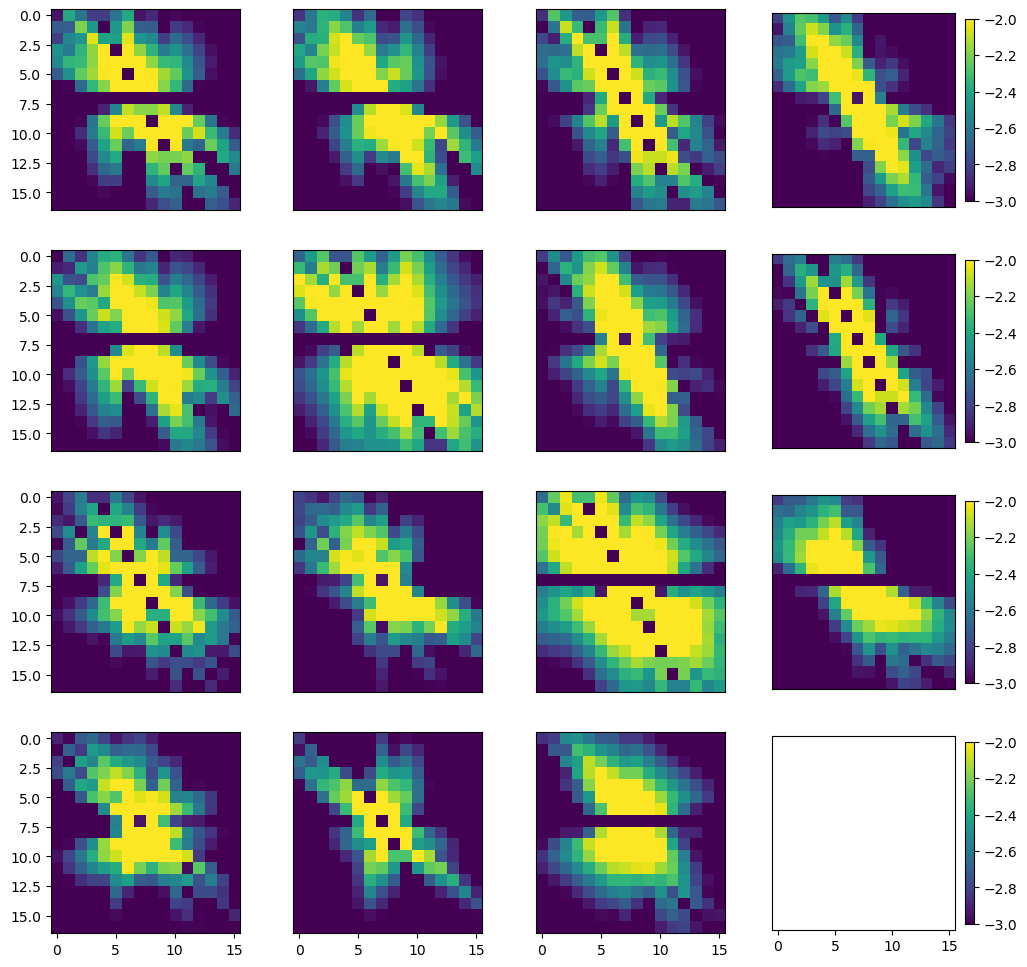

In [82]:
fig, axs = subplots(4,4, figsize=(12,12))


slice_dim = 3
for i in 1:4
    for j in 1:4
        iK = 4*(i-1) + j
        maxref = maximum(abs.(refval[:,:,:,TCI4Keldysh.KF_idx(iK,3)...]))
        diff = log10.(abs.(testval[:,:,:, TCI4Keldysh.KF_idx(iK,3)...] - refval[:,:,:, TCI4Keldysh.KF_idx(iK,3)...]) ./ maxref)
        vmax = -2
        vmin = -3

        # plot
        szV = size(testval)
        slice_idx = div(szV[slice_dim],2) - 0
        slice = ntuple(i -> ifelse(i==slice_dim, slice_idx, Colon()), 3)


        p = axs[i-1,j-1].imshow(diff[slice...], cmap="viridis", interpolation="nearest")
        # axs[i-1,j-1].set_title("$iK")
        axs[i-1,j-1].tick_params(axis="both", bottom=(i==4), labelbottom=(i==4), labelleft=(j==1), left=(j==1))
        p.set_clim(vmin, vmax)

        if j==4
            # colorbar
            fig.colorbar(p, fraction=0.045, ax=axs[i-1,3], location="right")
        end
    end
end

display(fig)

In [2]:
# print all Keldysh indices
for iK in 1:16
    println("iK=$iK, k=$(TCI4Keldysh.KF_idx(iK,3))")
end

g1 = k -> (k[3],k[4],k[1],k[2]) 
g2 = k -> (k[2],k[1],k[4],k[3])
ops = [g1,g2, k -> g1(g2(k))]
TCI4Keldysh.group_orbits(Set(TCI4Keldysh.KF_idx.(1:16,3)), ops)

iK=1, k=(1, 1, 1, 1)
iK=2, k=(2, 1, 1, 1)
iK=3, k=(1, 2, 1, 1)
iK=4, k=(2, 2, 1, 1)
iK=5, k=(1, 1, 2, 1)
iK=6, k=(2, 1, 2, 1)
iK=7, k=(1, 2, 2, 1)
iK=8, k=(2, 2, 2, 1)
iK=9, k=(1, 1, 1, 2)
iK=10, k=(2, 1, 1, 2)
iK=11, k=(1, 2, 1, 2)
iK=12, k=(2, 2, 1, 2)
iK=13, k=(1, 1, 2, 2)
iK=14, k=(2, 1, 2, 2)
iK=15, k=(1, 2, 2, 2)
iK=16, k=(2, 2, 2, 2)


7-element Vector{Set{NTuple{4, Int64}}}:
 Set([(2, 2, 2, 2)])
 Set([(2, 1, 2, 2), (2, 2, 2, 1), (2, 2, 1, 2), (1, 2, 2, 2)])
 Set([(1, 2, 1, 2), (2, 1, 2, 1)])
 Set([(1, 1, 1, 2), (1, 2, 1, 1), (2, 1, 1, 1), (1, 1, 2, 1)])
 Set([(1, 1, 2, 2), (2, 2, 1, 1)])
 Set([(1, 1, 1, 1)])
 Set([(2, 1, 1, 2), (1, 2, 2, 1)])

In [4]:
# check full Keldysh vertex
using MAT

channel = "t"
flavor_idx=1

basepath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50")
PSFpath = joinpath(basepath, "PSF_nz=4_conn_zavg/")
Vpath = joinpath(basepath, "V_KF_$(TCI4Keldysh.channel_translate(channel))")

T = TCI4Keldysh.dir_to_T(PSFpath)

# load MuNRG
Vref = nothing
ωs_ref = nothing
matopen(joinpath(Vpath, "V_KF_sym.mat")) do f
    CFdat = read(f, "CFdat")
    global Vref = CFdat["Ggrid"][flavor_idx]
    global ωs_ref = ntuple(i -> real.(vec(vec(CFdat["ogrid"])[i])), 3)
    global ωs_ref = ωs_ref[[3,1,2]]
end
Vref = permutedims(Vref, (3,1,2,4,5,6,7))
Vref = reverse(Vref; dims=(1,2,3))
@show size(Vref)

# Julia
(γ, sigmak) = TCI4Keldysh.read_broadening_params(basepath; channel=channel)
broadening_kwargs = TCI4Keldysh.read_broadening_settings(joinpath(TCI4Keldysh.datadir(), basepath); channel=channel)
if !haskey(broadening_kwargs, "estep")
    broadening_kwargs[:estep] = 20
end

# ωs_ext = ωs_ref
R = 4
Nhalf = 2^(R-1)
ωs_cen = [div(length(om), 2)+1 for om in ωs_ref]
@show [ωs_ref[i][ωs_cen[i]] for i in eachindex(ωs_ref)]
om_small = ntuple(i -> ωs_ref[i][ωs_cen[i] - Nhalf : ωs_cen[i] + Nhalf], 3)
Vfull = TCI4Keldysh.compute_Γfull_symmetric_estimator(
    "KF",
    PSFpath;
    T=T,
    flavor_idx=flavor_idx,
    ωs_ext=om_small,
    channel=channel,
    γ=γ,
    sigmak=sigmak,
    broadening_kwargs...
)
@show size(Vfull)

size(Vref) = (201, 201, 201, 2, 2, 2, 2)
[(ωs_ref[i])[ωs_cen[i]] for i = eachindex(ωs_ref)] = [0.0, 0.0, 0.0]
Loading stuff:   0.004745 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  34.161665 seconds (25.66 M allocations: 55.228 GiB, 34.42% gc time)
All the rest:   2.256152 seconds (205.46 k allocations: 1.560 GiB, 68.51% gc time)
Loading stuff:   0.001783 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  34.348915 seconds (25.66 M allocations: 55.228 GiB, 32.99% gc time)
All the rest:   2.273206 seconds (206.42 k allocations: 1.567 GiB, 65.18% gc time)
Loading stuff:   0.007963 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  34.793470 seconds (25.66 M allocations: 55.228 GiB, 33.30% gc time)
All the rest:   2.333895 seconds (206.42 k allocations: 1.567 GiB, 66.52% gc time)
size of Σ_vec:(33, 2, 2)
size of Σ_slanted: (17, 17, 2, 2)
size of Σ_vec:(33, 2, 2)
size of Σ_slanted: (17, 17, 2, 2)
letts: FFFF
Loading stuff:   1.897326 seconds 

(17, 17, 17, 2, 2, 2, 2)

In [14]:
include("plot_utils.jl")

function plot_alliK(data::Array{T,7}, slice_dim::Int, slice_idx::Int, scfun::Function=abs) where {T<:Number}
    fig, axs = subplots(4,4; figsize=(12,12))
    slice_tuple = ntuple(i -> ifelse(i==slice_dim, slice_idx, Colon()), 3)
    for ir in 1:4
        for ic in 1:4
            iK = 4*(ir-1) + ic
            axs[ir-1,ic-1].imshow(scfun.(data[slice_tuple..., TCI4Keldysh.KF_idx(iK,3)...]), cmap="viridis", interpolation="nearest")
            annotate_topleft(axs[ir-1,ic-1], "$(TCI4Keldysh.KF_idx(iK,3))"; color="white")  
        end
    end
    return fig, axs
end

"""
X,Y: from np.meshgrid(...)
"""
function plot_alliK_nonlinear(
        data::Array{T,7},
        X,
        Y,
        slice_dim::Int,
        slice_idx::Int,
        scfun::Function=abs
        ) where {T<:Number}
    fig, axs = subplots(4,4; figsize=(12,12))
    slice_tuple = ntuple(i -> ifelse(i==slice_dim, slice_idx, Colon()), 3)
    for ir in 1:4
        for ic in 1:4
            iK = 4*(ir-1) + ic
            axs[ir-1,ic-1].pcolormesh(X,Y, scfun.(data[slice_tuple..., TCI4Keldysh.KF_idx(iK,3)...]), cmap="viridis", shading="nearest")
            annotate_topleft(axs[ir-1,ic-1], "$(TCI4Keldysh.KF_idx(iK,3))"; color="white")  
        end
    end
    return fig, axs
end

plot_alliK_nonlinear

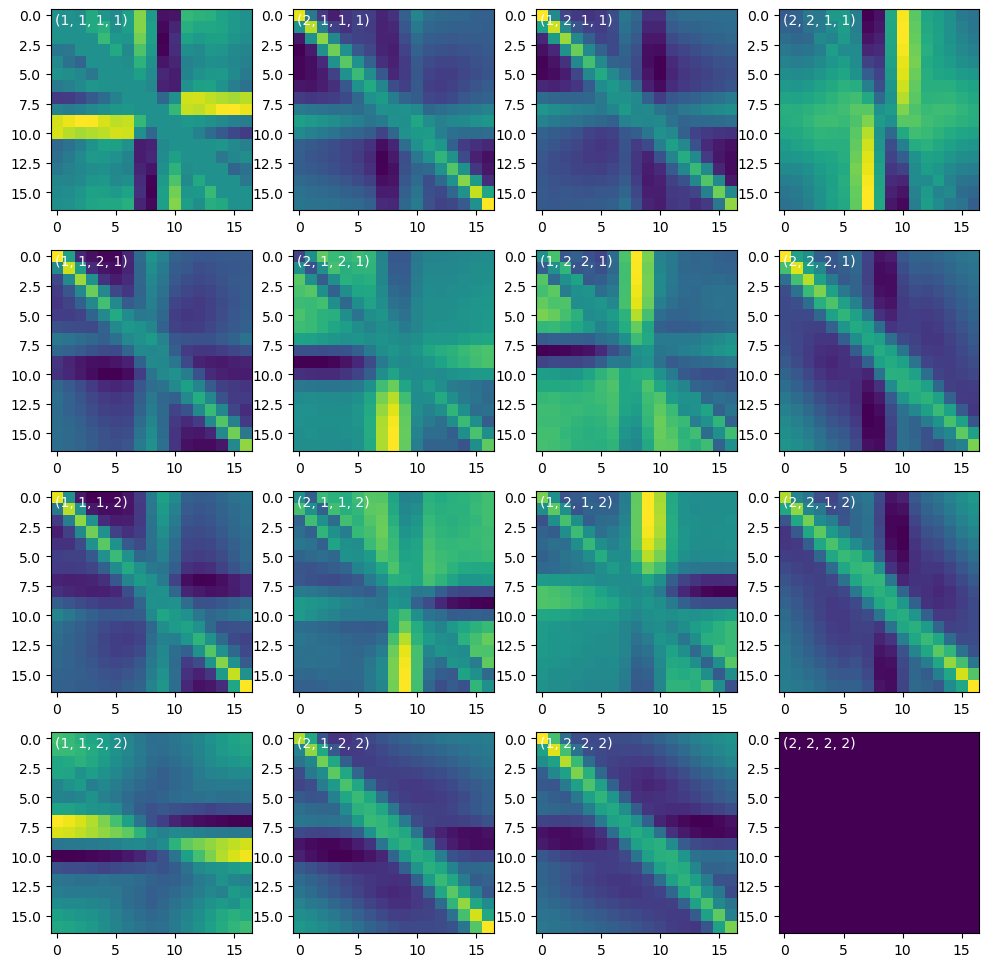

size(Vfull) = (17, 17, 17, 2, 2, 2, 2)
size(Vplot) = (17, 17, 17, 2, 2, 2, 2)
maximum(abs.(Vplot)) = 0.01734908345831503
maximum(abs.(Vfull)) = 0.01736043073003768
maximum(abs.(diff)) = 0.0006838413307280828


0.0006838413307280828

In [62]:
# plot Julia
fig, axs = subplots(4,4; figsize=(12,12))
slice_dim = 1
slice_idx = Nhalf
slice_tuple = ntuple(i -> ifelse(i==slice_dim, slice_idx, Colon()), 3)
scfun(x) = real(x)
for ir in 1:4
    for ic in 1:4
        iK = 4*(ir-1) + ic
        axs[ir-1,ic-1].imshow(scfun.(Vfull[slice_tuple..., TCI4Keldysh.KF_idx(iK,3)...]), cmap="viridis", interpolation="nearest")
    end
end
# display(fig)

# plot reference
Vplot = Vref[ntuple(i -> (ωs_cen[i]-Nhalf : ωs_cen[i]+Nhalf), 3)..., :,:,:,:]
@show size(Vfull)
@show size(Vplot)
fig, axs = subplots(4,4; figsize=(12,12))
slice_tuple = ntuple(i -> ifelse(i==slice_dim, slice_idx, Colon()), 3)
for ir in 1:4
    for ic in 1:4
        iK = 4*(ir-1) + ic
        axs[ir-1,ic-1].imshow(scfun.(Vplot[slice_tuple..., TCI4Keldysh.KF_idx(iK,3)...]), cmap="viridis", interpolation="nearest")
    end
end
# display(fig)

diff = Vplot .- Vfull
fig,_ = plot_alliK(diff, slice_dim, slice_idx, scfun)
display(fig)
@show maximum(abs.(Vplot))
@show maximum(abs.(Vfull))
@show maximum(abs.(diff))

In [3]:
# compare K1 only
using HDF5
using MAT
channel = "t"

function adjust_matdata(data::Array)
    out = permutedims(data, (3,1,2,4,5,6,7))
    out = reverse(out; dims=(1,2,3))
    return out
end

# julia data
juliadatapath = joinpath(TCI4Keldysh.pdatadir(), "V_KF_JULIA", "V_KF_$(TCI4Keldysh.channel_translate(channel))")
K1t = h5read(joinpath(juliadatapath, "V_KF_U2_ph.h5"), "K1")
K1p = h5read(joinpath(juliadatapath, "V_KF_U2_pp.h5"), "K1")
K1a = h5read(joinpath(juliadatapath, "V_KF_U2_pht.h5"), "K1")

# MuNRG data
refdatapath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50", "V_KF_$(TCI4Keldysh.channel_translate(channel))")
function _readMAT!(filename; flavor_idx::Int=1)
    out = nothing
    matopen(joinpath(refdatapath, filename)) do f
        CFdat = read(f, "CFdat")
        out = CFdat["Ggrid"][flavor_idx]
        out = adjust_matdata(out)
    end
    return out
end
# t
K1tref = _readMAT!("V_KF_U2_1.mat")
# p
K1pref = _readMAT!("V_KF_U2_2.mat")
# a
K1aref = _readMAT!("V_KF_U2_3.mat")
nothing

In [35]:
println(TCI4Keldysh.equivalent_iK_K1((1,1), "t"))
println(TCI4Keldysh.equivalent_iK_K1((2,1), "t"))
println(TCI4Keldysh.equivalent_iK_K1((1,2), "t"))
println(TCI4Keldysh.equivalent_iK_K1((2,2), "t"))

Any[[1, 1, 1, 1], [2, 2, 1, 1], [1, 1, 2, 2], [2, 2, 2, 2]]
Any[[1, 2, 1, 1], [2, 1, 1, 1], [1, 2, 2, 2], [2, 1, 2, 2]]
Any[[1, 1, 1, 2], [2, 2, 1, 2], [1, 1, 2, 1], [2, 2, 2, 1]]
Any[[1, 2, 1, 2], [2, 1, 1, 2], [1, 2, 2, 1], [2, 1, 2, 1]]


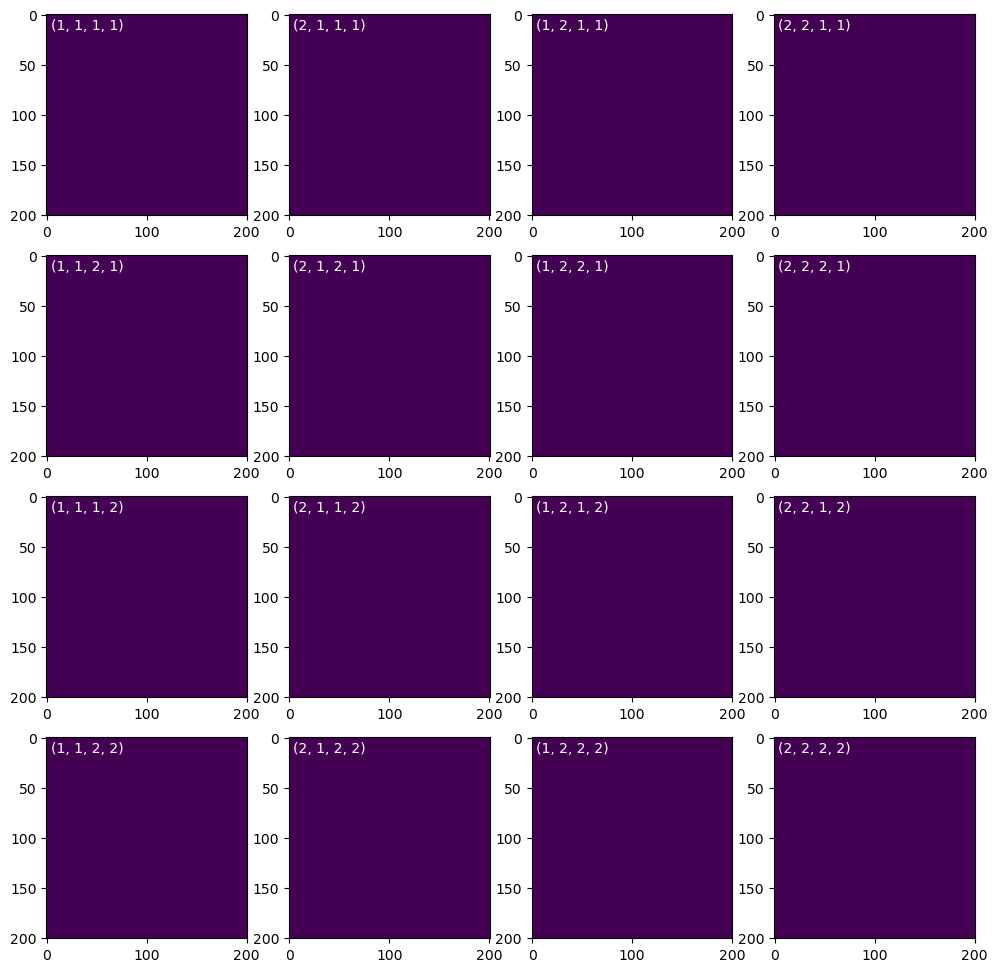

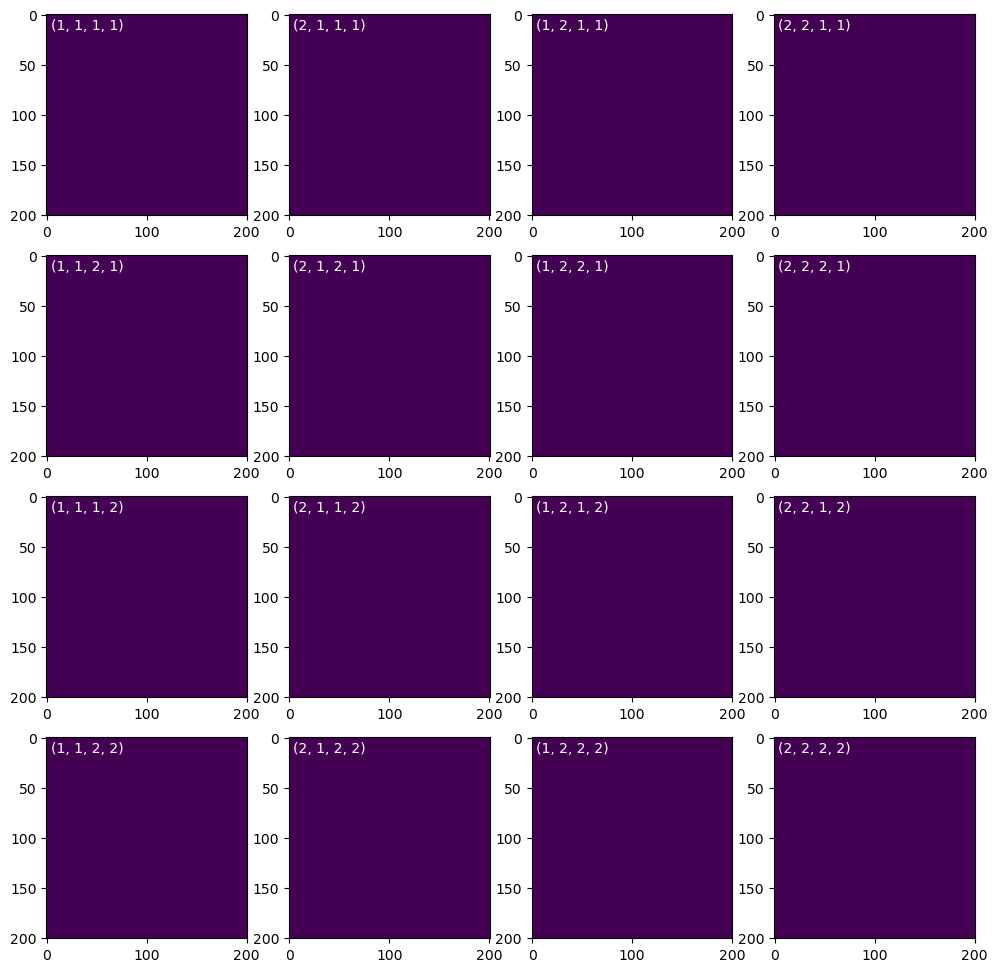

In [55]:
fig, _ = plot_alliK(K1t, 1, 8, imag)
display(fig)

fig, _ = plot_alliK(K1tref, 1, 100, imag)
display(fig)
fig, _ = plot_alliK(K1tref, 1, 1, imag)
display(fig)

In [37]:
# compare K2 only
using HDF5
using MAT
channel = "t"

function adjust_matdata(data::Array)
    out = permutedims(data, (3,1,2,4,5,6,7))
    out = reverse(out; dims=(1,2,3))
    return out
end

# julia data
juliadatapath = joinpath(TCI4Keldysh.pdatadir(), "V_KF_JULIA", "V_KF_$(TCI4Keldysh.channel_translate(channel))")
K2t = h5read(joinpath(juliadatapath, "V_KF_U3_ph_false.h5"), "K2")
K2p = h5read(joinpath(juliadatapath, "V_KF_U3_pp_false.h5"), "K2")
K2a = h5read(joinpath(juliadatapath, "V_KF_U3_pht_false.h5"), "K2")
K2t_prime = h5read(joinpath(juliadatapath, "V_KF_U3_ph_true.h5"), "K2")
K2p_prime = h5read(joinpath(juliadatapath, "V_KF_U3_pp_true.h5"), "K2")
K2a_prime = h5read(joinpath(juliadatapath, "V_KF_U3_pht_true.h5"), "K2")

# MuNRG data
refdatapath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50", "V_KF_$(TCI4Keldysh.channel_translate(channel))")
function _readMAT!(filename; flavor_idx::Int=1)
    out = nothing
    matopen(joinpath(refdatapath, filename)) do f
        CFdat = read(f, "CFdat")
        out = CFdat["Ggrid"][flavor_idx]
        out = adjust_matdata(out)
    end
    return out
end
# t
K2tref_prime = _readMAT!("V_KF_U3_1.mat")
K2tref = _readMAT!("V_KF_U3_6.mat")
# p
K2pref_prime = _readMAT!("V_KF_U3_2.mat")
K2pref = _readMAT!("V_KF_U3_5.mat")
# a
K2aref_prime = _readMAT!("V_KF_U3_3.mat")
K2aref = _readMAT!("V_KF_U3_4.mat")
nothing

In [38]:
for ik in TCI4Keldysh.ids_KF(3)
    println("$ik: $(TCI4Keldysh.equivalent_iK_K2(ik, "t", false))")
end

(1, 1, 1): Any[[1, 1, 1, 1], [1, 1, 2, 2]]
(2, 1, 1): Any[[1, 1, 1, 2], [1, 1, 2, 1]]
(1, 2, 1): Any[[2, 1, 1, 1], [2, 1, 2, 2]]
(2, 2, 1): Any[[2, 1, 1, 2], [2, 1, 2, 1]]
(1, 1, 2): Any[[1, 2, 1, 1], [1, 2, 2, 2]]
(2, 1, 2): Any[[1, 2, 1, 2], [1, 2, 2, 1]]
(1, 2, 2): Any[[2, 2, 1, 1], [2, 2, 2, 2]]
(2, 2, 2): Any[[2, 2, 1, 2], [2, 2, 2, 1]]


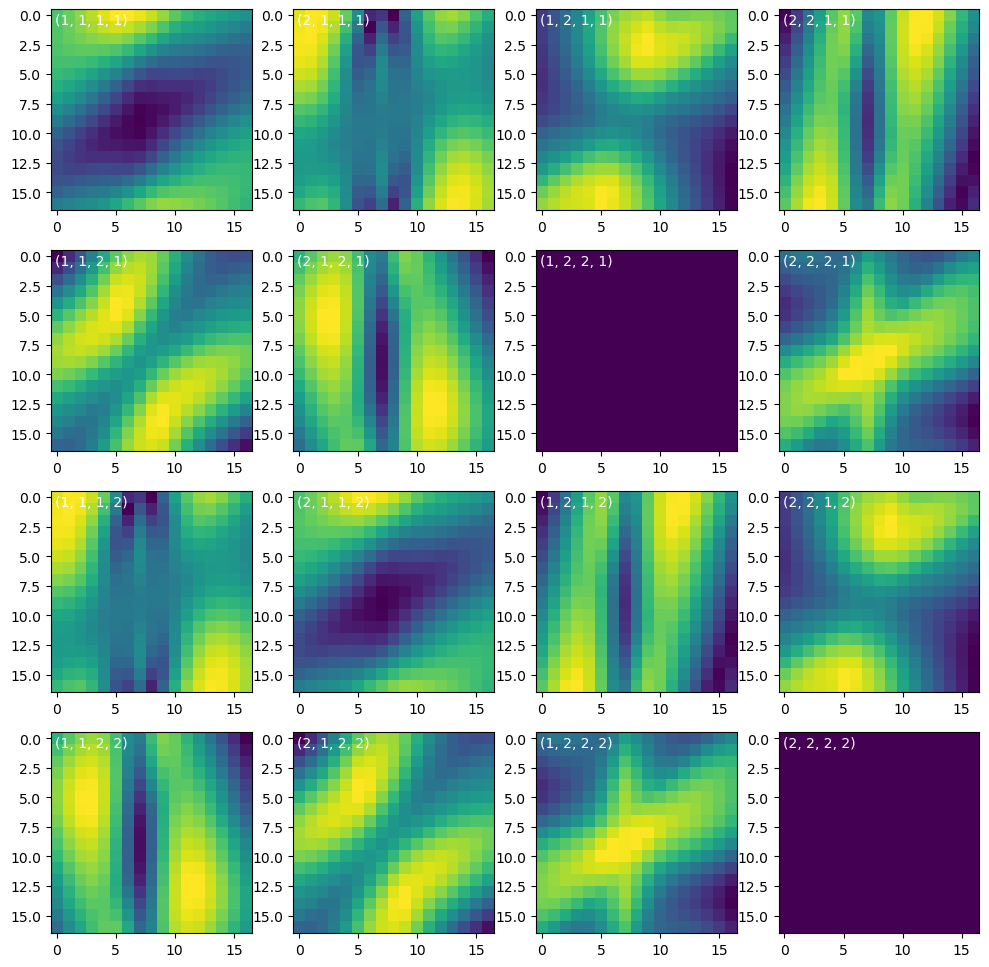

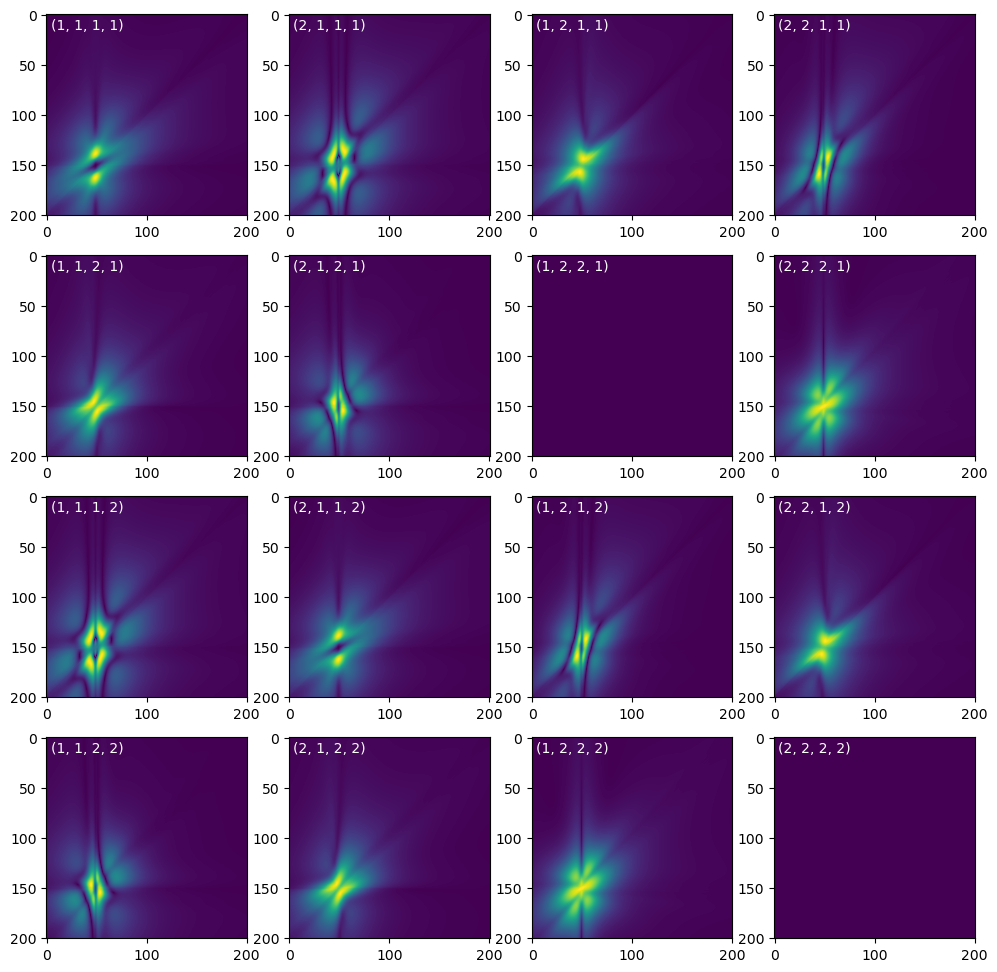

In [59]:
fig, _ = plot_alliK(K2a_prime, 2, 8)
display(fig)
fig, _ = plot_alliK(K2aref_prime, 2, 50)
display(fig)
# @show norm(K2p)
# @show norm(K2p_prime)
# @show norm(K2pref)
# @show norm(K2pref_prime)

### Evaluation on nonlinear grids (for Nepomuk)

In [ ]:
using HDF5 
using TCI4Keldysh
using LinearAlgebra

base_path = "SIAM_u=0.50"
PSFpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
flavor_idx = 1
# reference
V_ref = h5read(joinpath("../cluster_output/V_KF_conventional/V_KF_p_R=8.h5"), "V_KF")
om1 = h5read(joinpath("../cluster_output/V_KF_conventional/V_KF_p_R=8.h5"), "omgrid1")
om2 = h5read(joinpath("../cluster_output/V_KF_conventional/V_KF_p_R=8.h5"), "omgrid2")
om3 = h5read(joinpath("../cluster_output/V_KF_conventional/V_KF_p_R=8.h5"), "omgrid3")
ωs_ext = TCI4Keldysh.KF_grid(1.11 * om1[end], 9, 3)
iK = 2
channel = "p"
broadening_kwargs = TCI4Keldysh.read_all_broadening_params(base_path; channel=channel)
broadening_kwargs[:estep]=20

gev = TCI4Keldysh.ΓcoreEvaluator_KF(
    PSFpath,
    iK,
    ωs_ext,
    TCI4Keldysh.MultipoleKFCEvaluator;
    channel=channel,
    flavor_idx=flavor_idx,
    KEV_kwargs=Dict([(:nlevel, 4), (:cutoff, 1.e-10)]),
    broadening_kwargs...
)

gpgrids = TCI4Keldysh.Gp_grids(ωs_ext, TCI4Keldysh.channel_trafo(channel))

GFevs = [((w1,w2,w3) -> TCI4Keldysh.eval_interpol(G, gpgrids, w1,w2,w3)) for G in gev.GFevs]

omsig = TCI4Keldysh.Σ_grid(ωs_ext[1:2])

function sev_(il::Int, inc::Bool, w::Vararg{Float64,3})
    return TCI4Keldysh.eval_interpol(gev.sev, il, inc, omsig, w...)
end

maxref = maximum(abs.(V_ref))
omids = Base.OneTo.(length.((om1,om2,om3)))

function __f(w::Vararg{Float64,3})
    val = TCI4Keldysh.eval_Γcore_general(
        GFevs,
        sev_,
        gev.is_incoming,
        gev.letter_combinations,
        w...
        )
    return val
end


letts: FFFF
Loading stuff:   5.928121 seconds (158.61 k allocations: 366.216 MiB, 12.99% gc time, 3.56% compilation time)
Creating Broadened PSFs:   6.286072 seconds (4.31 M allocations: 893.045 MiB, 11.21% gc time, 81.63% compilation time)
All the rest:   9.633739 seconds (1.55 M allocations: 1.031 GiB, 78.14% gc time, 16.47% compilation time)
letts: FFFQ
Loading stuff:   5.285300 seconds (4.41 k allocations: 355.497 MiB, 9.12% gc time)
Creating Broadened PSFs:   1.111487 seconds (990.03 k allocations: 684.117 MiB, 58.06% gc time)
All the rest:   8.110809 seconds (86.33 k allocations: 961.029 MiB, 93.63% gc time)
letts: FFQF
Loading stuff:   5.151293 seconds (4.41 k allocations: 355.497 MiB, 8.31% gc time)
Creating Broadened PSFs:   1.474962 seconds (990.03 k allocations: 684.117 MiB, 66.73% gc time)
All the rest:   8.434146 seconds (86.33 k allocations: 961.029 MiB, 93.33% gc time)
letts: FFQQ
Loading stuff:   5.258569 seconds (4.41 k allocations: 355.498 MiB, 7.73% gc time)
Creating

In [1]:
abserrs = Float64[]
normederrs = Float64[]
for ic in Iterators.product(ntuple(i->omids[i][2:end-1], 3)...)
    if rand()>1.e-4
        continue
    end
    w = (om1[ic[1]], om2[ic[2]], om3[ic[3]])
    val = TCI4Keldysh.eval_Γcore_general(
        GFevs,
        sev_,
        gev.is_incoming,
        gev.letter_combinations,
        w...
        )
    ref = V_ref[ic...,:,:,:,:]
end

@show maximum(abserrs)
@show maximum(normederrs)

3

In [ ]:
using BenchmarkTools
using Profile
using StatProfilerHTML
w = ntuple(_->0.01, 3)
@btime begin
val = TCI4Keldysh.eval_Γcore_general(
        $GFevs,
        $sev_,
        $gev.is_incoming,
        $gev.letter_combinations,
        $w...
        )
end
Profile.clear()
@profile begin
    for _ in 1:100
        val = TCI4Keldysh.eval_Γcore_general(
                GFevs,
                sev_,
                gev.is_incoming,
                gev.letter_combinations,
                w...
                )
    end
end

statprofilehtml()

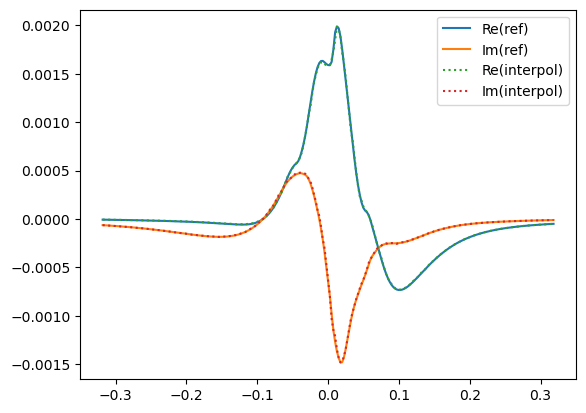

In [14]:
# plot lines

fig, axs = subplots()

iK = 2
idnu = 150
idnup = 110
axs.plot(om1, real.(V_ref[:,idnu,idnup, TCI4Keldysh.KF_idx(iK,3)...]); label="Re(ref)")
axs.plot(om1, imag.(V_ref[:,idnu,idnup, TCI4Keldysh.KF_idx(iK,3)...]); label="Im(ref)")

interpol = zeros(ComplexF64, length(om1))
for i in eachindex(om1)
    w = (om1[i],om2[idnu], om2[idnup])
    val = TCI4Keldysh.eval_Γcore_general(
            GFevs,
            sev_,
            gev.is_incoming,
            gev.letter_combinations,
            w...
            )
    interpol[i] = val[TCI4Keldysh.KF_idx(iK,3)...]
end
axs.plot(om1, real.(interpol); label="Re(interpol)", linestyle="dotted")
axs.plot(om1, imag.(interpol); label="Im(interpol)", linestyle="dotted")
axs.legend()

display(fig)

In [39]:
using HDF5

h5open("../foo_strong.h5") do f
    global ref = read(f, "V_KF_ref")
    global test = read(f, "V_KF_test")
end
nothing

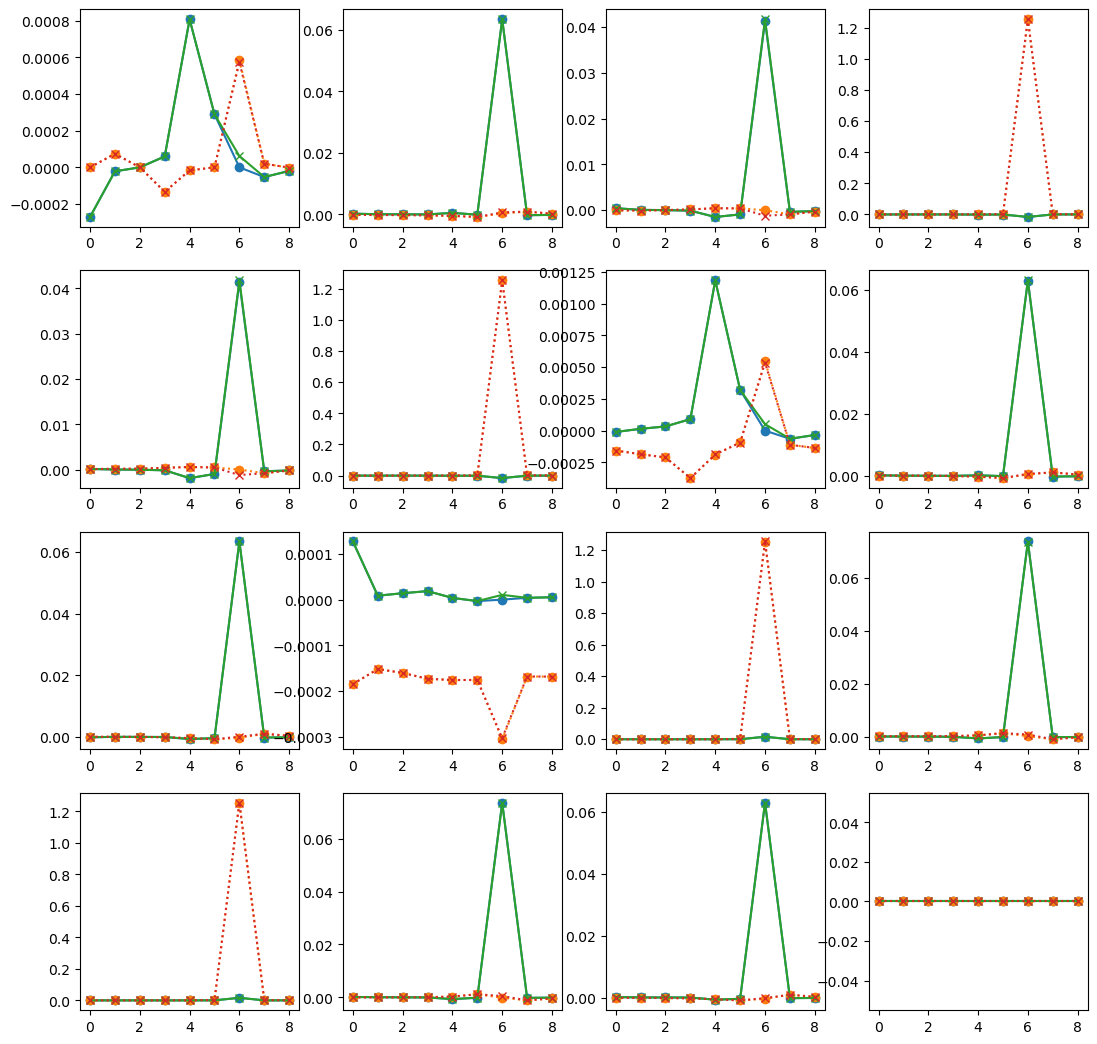

In [41]:
fig, axs = subplots(4,4, figsize=(13,13))

slice = (4,7,Colon())
for i in 1:4
    for j in 1:4
        iK = 4*(i-1) + j
        iKtuple = TCI4Keldysh.KF_idx(iK,3)
        axs[i-1,j-1].plot(real.(ref[slice...,iKtuple...]), marker="o")
        axs[i-1,j-1].plot(imag.(ref[slice...,iKtuple...]), marker="o", linestyle="dotted")
        axs[i-1,j-1].plot(real.(test[slice...,iKtuple...]), marker="x")
        axs[i-1,j-1].plot(imag.(test[slice...,iKtuple...]), linestyle="dotted", marker="x")
    end
end
display(fig)

In [34]:
# check out results
using HDF5

datapath = joinpath(TCI4Keldysh.pdatadir(), "cluster_output/loggrid30/V_KF.h5")
gridpath = joinpath(TCI4Keldysh.pdatadir(), "loggrid30.h5")
core = h5read(datapath, "core")
core = permutedims(core, [5,6,7,1,2,3,4])
grid = h5read(gridpath, "om1")

243-element Vector{Float64}:
 -100.0
  -92.61187281287933
  -85.76958985908941
  -79.43282347242814
  -73.56422544596414
  -68.12920690579611
  -63.09573444801933
  -58.434141337351754
  -54.116952654646376
  -50.11872336272722
    ⋮
   54.116952654646376
   58.434141337351754
   63.09573444801933
   68.12920690579611
   73.56422544596414
   79.43282347242814
   85.76958985908941
   92.61187281287933
  100.0

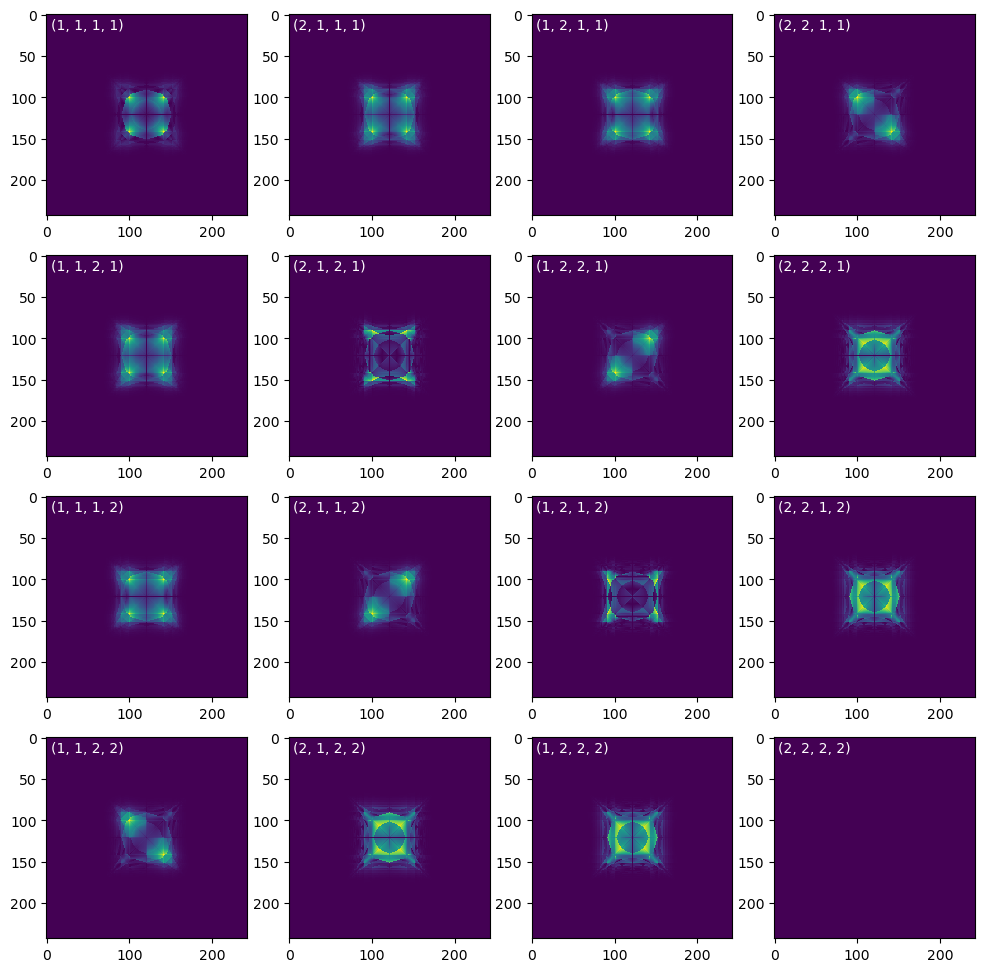

length(grid) = 243
grid[122] = 0.0


In [36]:
@show length(grid)
@show grid[122]
# fig, axs = plot_alliK_nonlinear(core, X, Y, 1, 82)
fig, axs = plot_alliK(core, 1, 122)
display(fig)

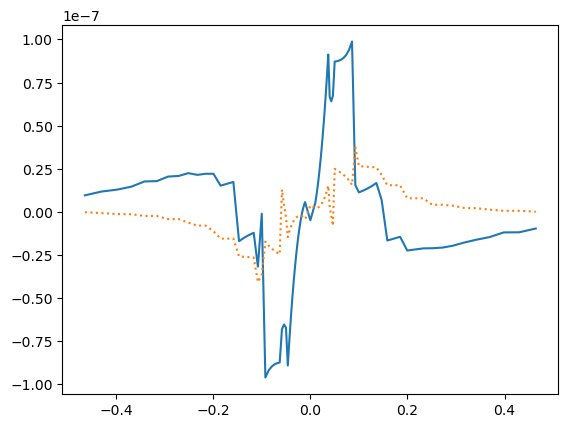

In [38]:
fig, axs = subplots()
iK = 2
ommax = 0.5
ids = abs.(grid) .< ommax
axs.plot(grid[ids], real.(core[121,50,ids, TCI4Keldysh.KF_idx(iK,3)...]); linestyle="solid")
axs.plot(grid[ids], imag.(core[121,50,ids, TCI4Keldysh.KF_idx(iK,3)...]); linestyle="dotted")
display(fig)